In [1]:
# Import necessary libraries
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim.models import LdaModel
from collections import Counter

In [2]:
df = pd.read_pickle('negative_sentiment_df.pkl')
df.head()

,productAsin,country,date,isVerified,ratingScore,reviewUrl,reviewedIn,variant,variantAsin,reviews,sentiment_scores,sentiment,rating_sentiment
16,B09G9BL5CP,India,31-10-2023,True,3,https://www.amazon.in/gp/customer-reviews/R2WH...,Reviewed in India on 31 October 2023,Colour: PinkSize: 256 GB,B09G9HRYFZ,week since using phone work fine nothing speci...,0.7463,positive,negative
19,B09G9BL5CP,India,14-02-2024,True,2,https://www.amazon.in/gp/customer-reviews/R2TD...,Reviewed in India on 14 February 2024,Colour: PinkSize: 256 GB,B09G9HRYFZ,device not working need help device not workin...,-0.3089,negative,negative
21,B09G9BL5CP,India,25-06-2024,True,3,https://www.amazon.in/gp/customer-reviews/R3S8...,Reviewed in India on 25 June 2024,Colour: BlueSize: 256 GB,B09G93H3BR,not worth not worth,-0.3252,negative,negative
22,B09G9BL5CP,India,12-05-2024,True,3,https://www.amazon.in/gp/customer-reviews/R2QO...,Reviewed in India on 12 May 2024,Colour: BlueSize: 256 GB,B09G93H3BR,improved version iphone nothing new feature mo...,0.4767,positive,negative
23,B09G9BL5CP,India,21-07-2024,True,2,https://www.amazon.in/gp/customer-reviews/R2QY...,Reviewed in India on 21 July 2024,Colour: BlueSize: 256 GB,B09G93H3BR,doubtful seal teared stricker put know whether...,-0.3400,negative,negative


In [22]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

# Set of generic negative words and bigrams to be ignored
generic_negative_words = {
    'phone', 'bad', 'terrible', 'horrible', 'worst', 'awful', 'disappointing', 
    'hate', 'poor', 'didn\'t', 'doesn\'t', 'not', 'never', 'problem', 'issue', 
    'waste', 'product', 'return','good', 'not good', ' ', '\u200e', '\'', '’'
}

def extract_words(review):
    words = word_tokenize(review.lower())
    words = [word for word in words if word not in generic_negative_words]
    
    # Extract bigrams
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(words)
    finder.apply_freq_filter(1)  # Only bigrams that appear at least twice
    bigrams = finder.nbest(bigram_measures.pmi, 10)
    
    return words, bigrams

important_words = []
important_bigrams = []
for review in df['reviews']:
    words, bigrams = extract_words(review)
    important_words.extend(words)
    important_bigrams.extend(bigrams)

In [23]:
# Count and get top words
word_counts = Counter(important_words)
top_words = word_counts.most_common(10)

# Filter bigrams to only include those with top words
top_word_set = set(word for word, _ in top_words)
filtered_bigrams = [bigram for bigram in important_bigrams if bigram[0] in top_word_set or bigram[1] in top_word_set]

# Count and get top filtered bigrams
bigram_counts = Counter(filtered_bigrams)
top_bigrams = bigram_counts.most_common(10)

print(top_words)
print(top_bigrams)

[('iphone', 1529), ('battery', 952), ('camera', 771), ('apple', 621), ('great', 518), ('quality', 504), ('like', 457), ('amazon', 449), ('new', 442), ('one', 392)]
[(('battery', 'life'), 132), (('camera', 'quality'), 106), (('brand', 'new'), 60), (('battery', 'health'), 45), (('battery', 'backup'), 36), (('like', 'new'), 34), (('look', 'like'), 23), (('battery', 'capacity'), 22), (('iphone', 'best'), 21), (('build', 'quality'), 20)]


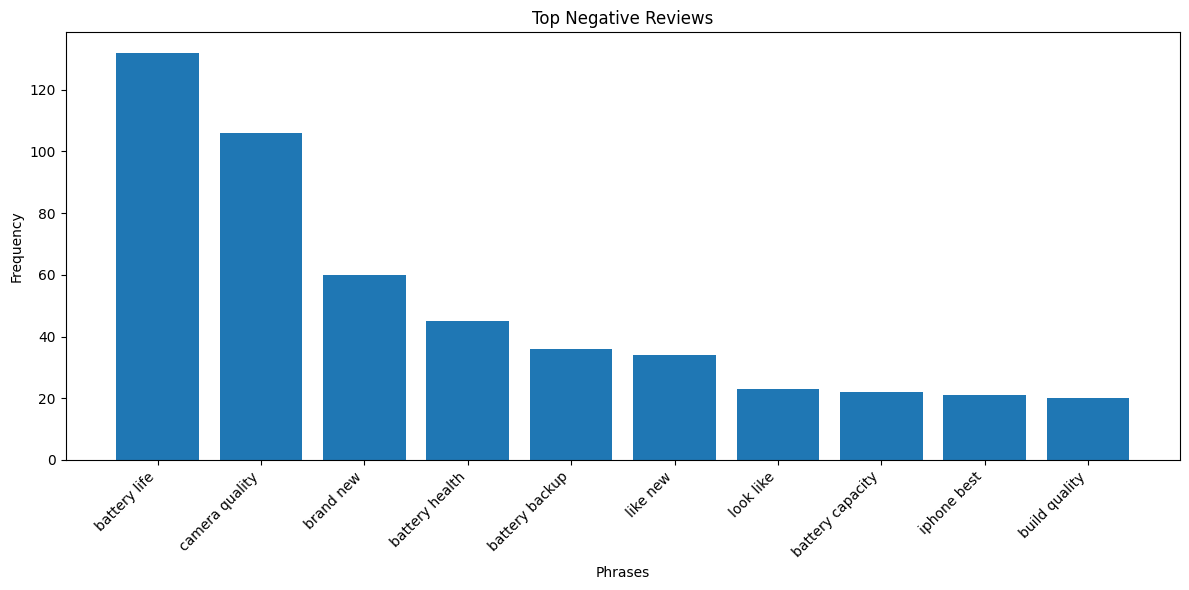

In [26]:
import matplotlib.pyplot as plt

# Count the filtered bigrams
filtered_bigram_counts = Counter(filtered_bigrams)

# Get the top N bigrams (e.g., top 10)
top_filtered_bigrams = filtered_bigram_counts.most_common(10)

# Plot top filtered bigrams
plt.figure(figsize=(12, 6))
plt.bar([' '.join(bigram) for bigram, count in top_filtered_bigrams], [count for bigram, count in top_filtered_bigrams])
plt.title('Top Negative Reviews')
plt.xlabel('Phrases')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Load the sentiment analysis DataFrame
df = pd.read_pickle('sentiment_analysis_df.pkl')

# Define categories for negative reviews based on sentiment scores
def categorize_negative_sentiment(score):
    if score <= 0.4:
        return 'Least Satisfied'
    elif 0.4 < score <= 0.6:
        return 'Somewhat Satisfied'
    else:
        return 'Not Negative'

df['negative_review_category'] = df['sentiment_scores'].apply(categorize_negative_sentiment)

# Filter for only negative reviews (exclude non-negative ones)
negative_df = df[df['negative_review_category'] != 'Not Negative']

# Ensure that the 'review_text' column contains valid strings
negative_reviews = negative_df['reviews'].dropna()

# Use CountVectorizer to extract frequent words/phrases from negative review text
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=50)
X = vectorizer.fit_transform(negative_reviews)

# Get the most frequent words/phrases
words = vectorizer.get_feature_names_out()
word_counts = X.sum(axis=0).A1  # Total count for each word/phrase
word_freq = pd.DataFrame({'word': words, 'count': word_counts}).sort_values(by='count', ascending=False)

print("Top words/phrases from negative reviews (suggestions for improvement):")
print(word_freq.head(10))  # Display the top 10 most frequent words/phrases



Top words/phrases from negative reviews (suggestions for improvement):
       word  count
31    phone    815
22   iphone    460
4   battery    350
35  product    343
18     good    287
2     apple    242
8    camera    221
0    amazon    209
7       buy    187
23    issue    181
